In [9]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

import networkx as nx

from scipy.cluster.hierarchy import dendrogram, linkage

In [10]:
# Hyperparameters
cuda = True
epochs = 10
log_interval = 400
batchSize = 16

hidden_layer_sizes = [3 * 32 * 32, 256, 10]

lr = 0.001

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])        
        # self.init_layers()
        
    def init_layers(self):
        
        for i, l in enumerate(self.linears):            
            norms = torch.norm(self.linears[i].weight.data, 2, 0).repeat(self.linears[i].weight.size(0), 1)
            self.linears[i].weight.data = self.linears[i].weight.data.div(norms * 0.587)
            
            bias = torch.FloatTensor(self.linears[i].weight.data.size(1), 1).fill_(.001)
            bias = torch.mm(self.linears[i].weight.data, bias)
            self.linears[i].bias.data.copy_(bias)
            

    def forward(self, x):
        activations = 0
        x = x.view(-1, 3 * 32 * 32)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            if i + 2 == len(hidden_layer_sizes):
                break
            if type(activations) is np.ndarray:
                activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
            else:
                activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (linears): ModuleList (
    (0): Linear (3072 -> 256)
    (1): Linear (256 -> 10)
  )
)


In [12]:
class Constellation():
    
    train_activations = 0
    
    def __init__(self):
        self.train_activations = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def num_linkage_below_threshold(self, Z, distance, num_elem):
        elem_in_linkage = len(Z)
        count_clusters = 0
        elems_seen = {}
        
        for i in Z:
            # Check if this cluster is made with a good distance.
            if i[2] <= distance:
                count_clusters += 1
                if i[0] >= elem_in_linkage:
                    count_clusters -= 1
                else:
                    elems_seen[i[0]] = 1
                if i[1] >= elem_in_linkage:
                    count_clusters -= 1 
                else:
                    elems_seen[i[1]] = 1
        count_clusters += num_elem - len(elems_seen.keys())
        
        # print('Number of clusters :%d ' % (count_clusters))
        return count_clusters
    
    def curve_clusters_count(self, Z, num_elem):
        X = np.arange(10, 200, 10)
        Y = []
        for i in X:
            Y += [self.num_linkage_below_threshold(Z, i, num_elem)]
        plt.plot(X, Y)
        plt.xlim(10, 200)
        plt.show()
                
        
    def print_metrics(self):
        print('Linkage ...')
        Z = linkage(256 * pdist(self.train_activations[:,0], metric='hamming'), 'complete', metric='precomputed')
        print('Linkage count ...')
        self.curve_clusters_count(Z, self.train_activations.shape[0])
#         print('Plot ...')
#         plt.figure(figsize=(25, 10))
#         plt.title('Hierarchical Clustering Dendrogram')
#         plt.xlabel('sample index')
#         plt.ylabel('distance')
#         dendrogram(
#             Z,
#             leaf_rotation=90.,  # rotates the x axis labels
#             leaf_font_size=8.,  # font size for the x axis labels
#             color_threshold = 100
#         )
#         plt.show()
        
        
        

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
if cuda:
    model.cuda()
    criterion.cuda()

In [15]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = Constellation()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 1000:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

Linkage ...
Linkage count ...


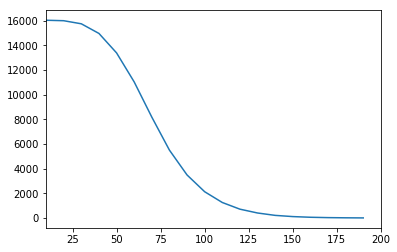

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.322587
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.094848
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.373034
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.463925
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.803776
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.781318
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.999379
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.983774

Test set: Average loss: 1.5569, Accuracy: 4576/10000 (46%)

Linkage ...
Linkage count ...


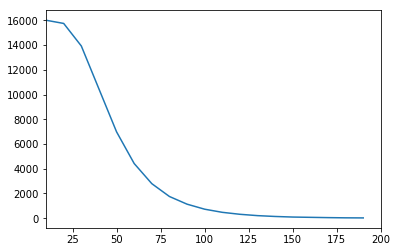

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.104328
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.481852
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.170340
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.528749
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.789408
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.000882
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.804460
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.692307

Test set: Average loss: 1.4699, Accuracy: 4876/10000 (49%)

Linkage ...
Linkage count ...


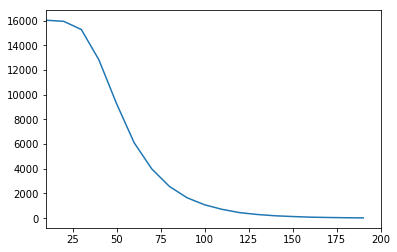

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.500077
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.258272
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.241004
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.977957
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.083735
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.445645
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.218001
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.313050

Test set: Average loss: 1.4309, Accuracy: 4979/10000 (50%)

Linkage ...
Linkage count ...


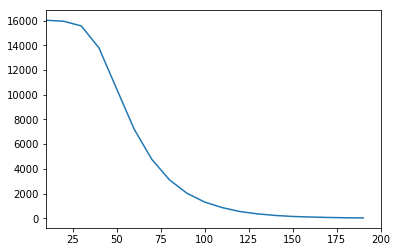

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.217783
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.969058
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.399604
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.520887
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.984508
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.043467
Train Epoch: 4 [38400/50000 (77%)]	Loss: 2.104485
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.814520

Test set: Average loss: 1.4090, Accuracy: 5094/10000 (51%)

Linkage ...
Linkage count ...


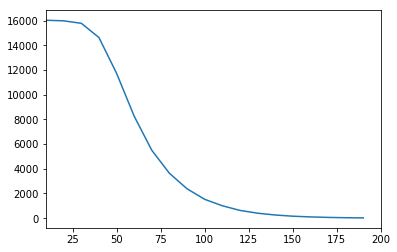

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.398757
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.036614
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.416179
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.358893
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.892080
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.326223
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.439029
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.222837

Test set: Average loss: 1.3852, Accuracy: 5163/10000 (52%)

Linkage ...
Linkage count ...


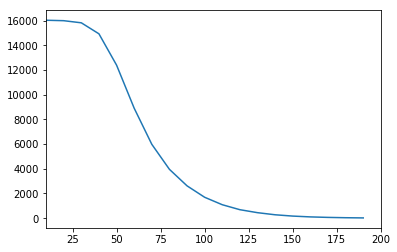

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.048606
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.565873
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.114115
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.419946
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.386181
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.122224
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.025322
Train Epoch: 6 [44800/50000 (90%)]	Loss: 0.590961


Process Process-35:
Process Process-36:
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    r = index_queue.get()
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", li

KeyboardInterrupt: 

In [16]:
# activation_metrics()

for epoch in range(1, epochs + 1):
    activation_metrics()
    train(epoch)
    test(epoch)